<a href="https://colab.research.google.com/github/MarcoParola/structural_health_monitoring/blob/main/convolutional_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional architectures to solve Damage Localization and Quantification problems**

In this notebook there are some implementation of convolutional neural network to solve the following tasks:


*   Multi-class classification, **damage localization task**
*   Regression, **damage quantification**



### Link Drive, import packages and declare global variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix
import tensorflow as tf

projectPath = 'drive/MyDrive/Colab Notebooks/thesis2/'

NUMBER_OF_CLASS = 9
TRUNCATE = 9000

# the most usefull sensors are: 1,5,9,12,14,15
filter_indeces = [1,5,9,12,14,15]

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     mode='min', verbose=1, 
                                                     patience=15, 
                                                     restore_best_weights=True)

In [ ]:
%cd $projectPath
%run utils.ipynb
%cd '../../../..'

/content/drive/MyDrive/Colab Notebooks/thesis2
/content


Load dataset and labels

In [ ]:
data = np.load(DATASET)

labels = load_dataset('damage_labels')
levels = load_dataset('damage_levels')

randomize = np.arange(len(labels))
np.random.shuffle(randomize)
data = data[randomize,:,:]
labels = labels[randomize]
levels = levels[randomize]

dataset = data[0:TRUNCATE, :, :]
testset = data[TRUNCATE:len(data), :, :]

labels_train = labels[0:TRUNCATE]
levels_train = levels[0:TRUNCATE]
labels_test = labels[TRUNCATE:len(labels)]
levels_test = levels[TRUNCATE:len(levels)]

labels_train = to_categorical(labels_train)
labels_test = to_categorical(labels_test)

print(dataset.shape)
print(testset.shape)

(9999,)
(9999,)
(9000, 1751, 6)
(999, 1751, 6)


# **Classification**

### classifier 1

Model: "classifier1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1751, 16)          3472      
                                                                 
 batch_normalization (BatchN  (None, 1751, 16)         64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 1751, 64)          28736     
                                                                 
 batch_normalization_1 (Batc  (None, 1751, 64)         256       
 hNormalization)                                                 
                                                                 
 global_average_pooling1d (G  (None, 64)               

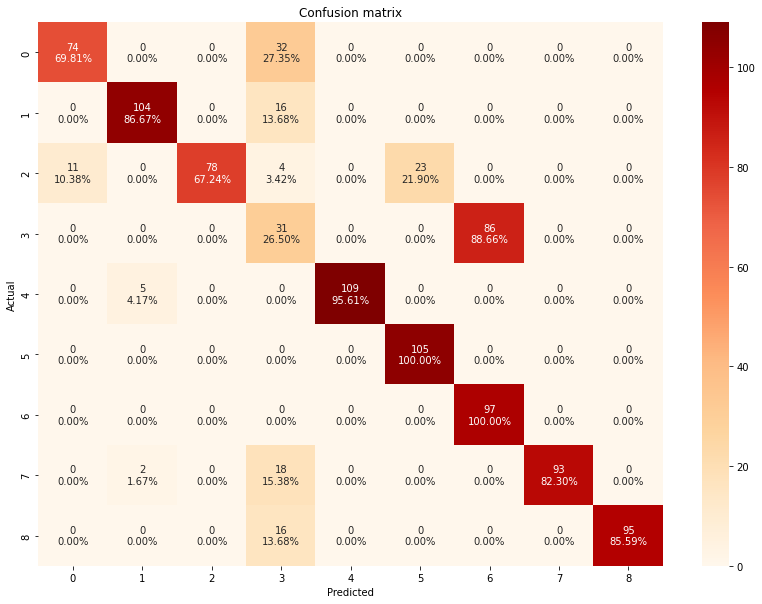

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), len(filter_indeces)))

x = layers.Conv1D(16,36, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(64, 28, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(NUMBER_OF_CLASS, activation='softmax')(x)

model = keras.Model(inputs, x, name='classifier1')
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(dataset, labels_train, epochs=40, callbacks=[earlyStopCallback], shuffle=True, batch_size=256, validation_split=0.2)

evaluateClassifier(model, testset, levels_test)

### classifier 2

Model: "classifier2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d_10 (Conv1D)          (None, 1751, 16)          3088      
                                                                 
 batch_normalization_4 (Batc  (None, 1751, 16)         64        
 hNormalization)                                                 
                                                                 
 conv1d_11 (Conv1D)          (None, 1751, 32)          12320     
                                                                 
 batch_normalization_5 (Batc  (None, 1751, 32)         128       
 hNormalization)                                                 
                                                                 
 global_average_pooling1d_2   (None, 32)               

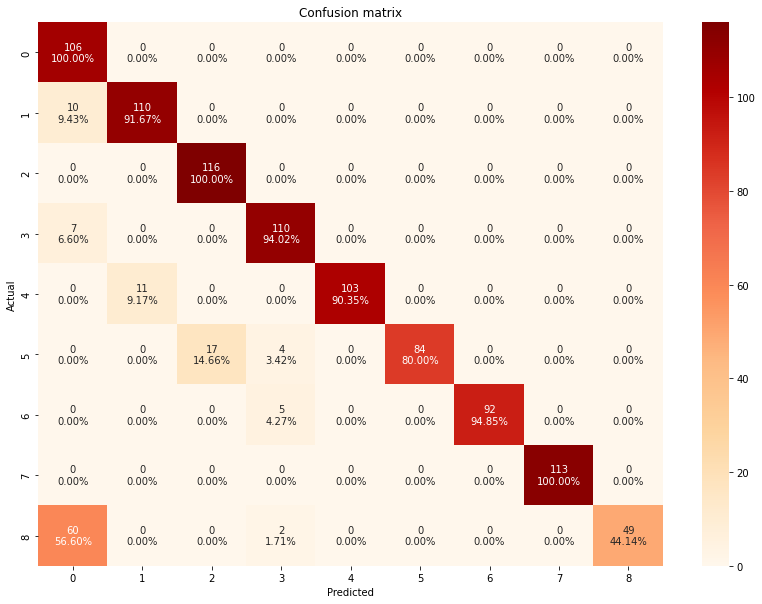

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), len(filter_indeces)))

x = layers.Conv1D(16, 32, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(32, 24, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(NUMBER_OF_CLASS, activation='softmax')(x)

model = keras.Model(inputs, x, name='classifier2')
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(dataset, labels_train, epochs=40, callbacks=[earlyStopCallback], shuffle=True, batch_size=128, validation_split=0.2)

evaluateClassifier(model, testset, levels_test)

### classifier 3

Model: "classifier3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1751, 16)          3088      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 219, 16)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 219, 16)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 219, 32)           10272     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 37, 32)           0         
 1D)                                                   

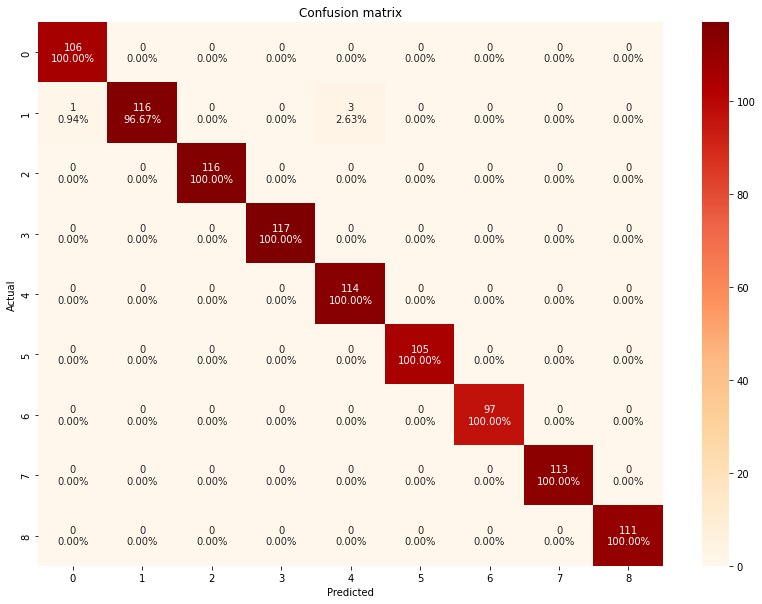

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))


x = layers.Conv1D(16, 32, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(8, padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(32, 20, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(6, padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(4, padding='same', name='last')(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten(name='encoer_flatted')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(NUMBER_OF_CLASS, activation='softmax')(x)

model = keras.Model(inputs, x, name='classifier3')
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(dataset, labels_train, epochs=130, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateClassifier(model, testset, levels_test)

In [ ]:
model.save(os.path.join(MODELS_PATH, "conv_classifier.h5")) 

# **Regression**

### regressor 1

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1751, 6)]         0         
                                                                 
 conv1d_30 (Conv1D)          (None, 1751, 16)          2416      
                                                                 
 batch_normalization_9 (Batc  (None, 1751, 16)         64        
 hNormalization)                                                 
                                                                 
 conv1d_31 (Conv1D)          (None, 1751, 32)          10272     
                                                                 
 batch_normalization_10 (Bat  (None, 1751, 32)         128       
 chNormalization)                                                
                                                                 
 global_average_pooling1d_5   (None, 32)               0    

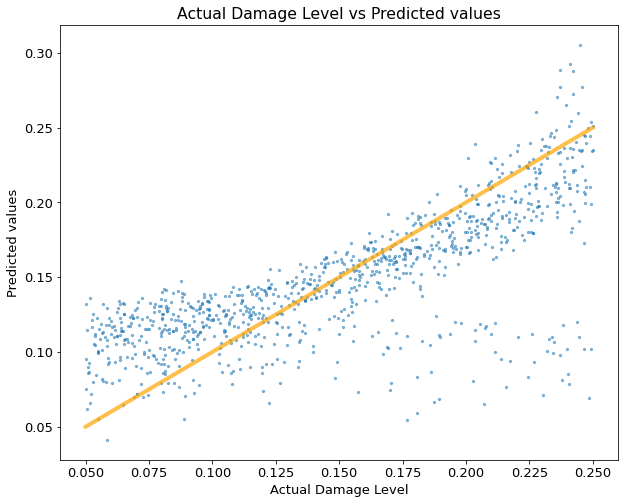

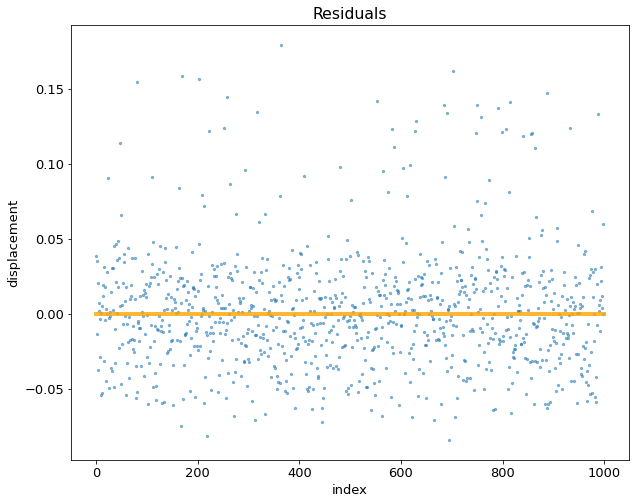

(0.9219622611999512, 2.5530618605925925e-22)


In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), len(filter_indeces)))


x = layers.Conv1D(16, 25, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(32, 20, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1)(x)

model = keras.Model(inputs, x, name='regressor1')
model.summary()


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(dataset, levels_train, epochs=150, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.2)

evaluateRegressor(model, testset, levels_test)

### regressor 2

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1751, 6)]         0         
                                                                 
 conv1d_32 (Conv1D)          (None, 1751, 16)          784       
                                                                 
 average_pooling1d_2 (Averag  (None, 351, 16)          0         
 ePooling1D)                                                     
                                                                 
 dropout_25 (Dropout)        (None, 351, 16)           0         
                                                                 
 conv1d_33 (Conv1D)          (None, 351, 32)           2592      
                                                                 
 average_pooling1d_3 (Averag  (None, 176, 32)          0         
 ePooling1D)                                                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


113/113 [==============================] - 3s 14ms/step - loss: 0.0199 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 2/150
113/113 [==============================] - 1s 12ms/step - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 3/150
113/113 [==============================] - 2s 14ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 4/150
113/113 [==============================] - 1s 12ms/step - loss: 0.0037 - accuracy: 0.0000e+00 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 5/150
113/113 [==============================] - 1s 12ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 6/150
113/113 [==============================] - 1s 12ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 7/150
113/113 [==============================] - 1s 12ms/step - loss: 0.0035 - accuracy: 0.000

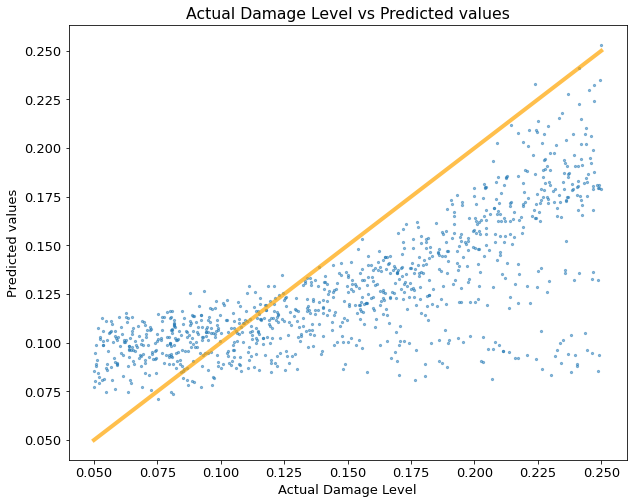

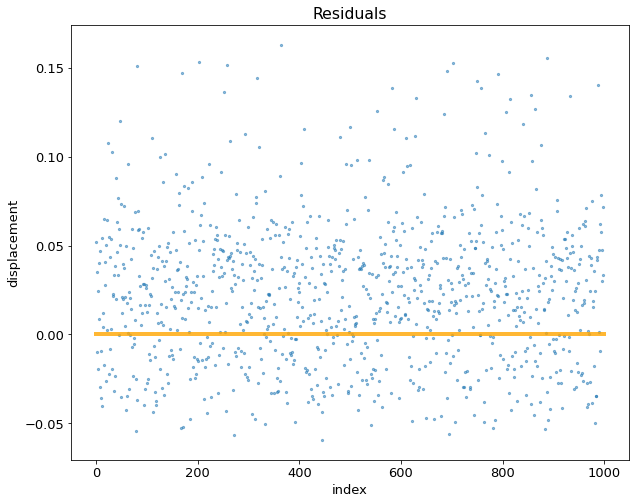

(0.9764277338981628, 1.1813709732688693e-11)


In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))


x = layers.Conv1D(16, 8, activation='relu', padding='same')(inputs)
x = layers.AveragePooling1D(5, padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = layers.AveragePooling1D(2, padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.AveragePooling1D(2, padding='same', name='last')(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten(name='encoer_flatted')(x)
x = layers.Dense(1)(x)

model = keras.Model(inputs, x, name='regressor2')
model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(dataset, levels_train, epochs=150, callbacks=[earlyStopCallback], batch_size=64, validation_split=0.2)

evaluateRegressor(model, testset, levels_test)

### regressor 3

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1751, 6)]         0         
                                                                 
 conv1d_35 (Conv1D)          (None, 1751, 16)          784       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 351, 16)          0         
 g1D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 351, 16)           0         
                                                                 
 conv1d_36 (Conv1D)          (None, 351, 32)           2592      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 176, 32)          0         
 g1D)                                                       

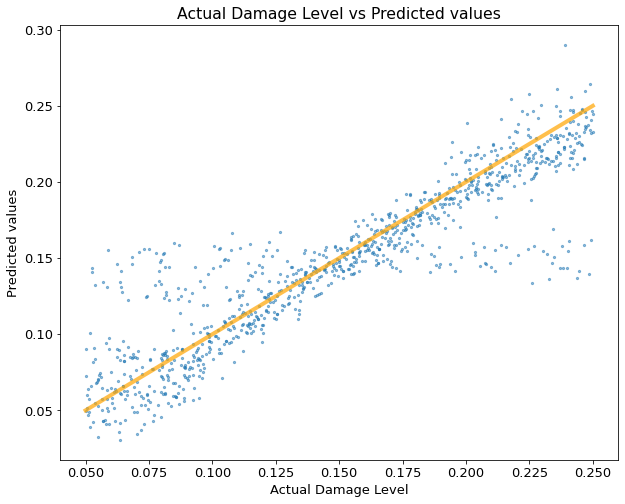

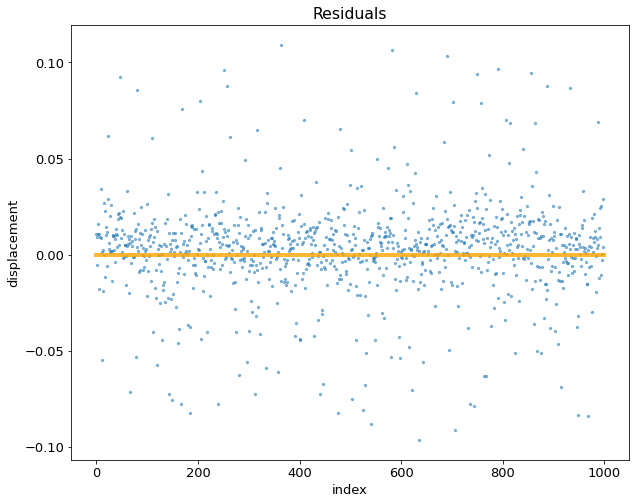

(0.8854131698608398, 1.532668146066984e-26)


In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(14) 

inputs = keras.Input(shape=(len(dataset[0]), 6))
x = layers.Conv1D(16, 8, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(5, padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1)(x)
model = keras.Model(inputs, x, name='regressor3')
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(dataset, levels_train, epochs=180, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateRegressor(model, testset, levels_test)

In [ ]:
model.save(os.path.join(MODELS_PATH, "conv_regressor.h5")) 

# **Models training on noisy data**

## noisy classifier 

*Signals corruption*: a noisy component is added to the signals (Gaussian noise) producing a signal with an SNR of about 3 dB 

In [ ]:
t = testset.copy()
noise = 0.07 * 4 * (np.random.randn(len(testset), len(testset[0]), len(testset[0,0])) *2 -1)
t = t + noise

d = dataset.copy()
noise = 0.07 * 4 * (np.random.randn(len(dataset), len(dataset[0]), len(dataset[0,0])) *2 -1)
d = d + noise

power_dataset = np.sum( np.abs(dataset)**2 ) / (len(dataset)* len(dataset[0])* len(dataset[0,0]))
power_noise = np.sum( np.abs(noise)**2 ) / (len(noise)* len(noise[0])* len(noise[0,0]))

print('SNR:', power_dataset / power_noise, '\n')

SNR: 2.550496855904725 



Classifier training using noisy data

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))

x = layers.Conv1D(16, 32, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(8, padding='same')(x)
x = layers.Conv1D(32, 20, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(6, padding='same')(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(4, padding='same', name='last')(x)

x = layers.Flatten(name='encoer_flatted')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(NUMBER_OF_CLASS, activation='softmax')(x)

noisy_classifier = keras.Model(inputs, x, name='noisy_classifier')
noisy_classifier.summary()

noisy_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = noisy_classifier.fit(d, labels_train, epochs=50, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateClassifier(noisy_classifier, t, labels_test)

Model: "noisy_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1751, 16)          3088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 219, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 219, 32)           10272     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 16)       

In [ ]:
noisy_classifier.save(os.path.join(MODELS_PATH, "conv_noisy_classifier.h5")) 

## noisy regressor

*Signals corruption*: a noisy component is added to the signals (Gaussian noise) producing a signal with an SNR of about 3 dB 

In [ ]:
t = testset.copy()
noise = 0.07 * 4 * (np.random.randn(len(testset), len(testset[0]), len(testset[0,0])) *2 -1)
t = t + noise

d = dataset.copy()
noise = 0.07 * 4 * (np.random.randn(len(dataset), len(dataset[0]), len(dataset[0,0])) *2 -1)
d = d + noise

power_dataset = np.sum( np.abs(dataset)**2 ) / (len(dataset)* len(dataset[0])* len(dataset[0,0]))
power_noise = np.sum( np.abs(noise)**2 ) / (len(noise)* len(noise[0])* len(noise[0,0]))

print('SNR:', power_dataset / power_noise, '\n')

SNR: 2.550625900745595 



Regressor training using 

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))
x = layers.Conv1D(16, 8, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(5, padding='same')(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1)(x)
noisy_regressor = keras.Model(inputs, x, name='noisy_regressor')
noisy_regressor.summary()

noisy_regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = noisy_regressor.fit(d, levels_train, epochs=180, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateRegressor(noisy_regressor, t, levels_test)

Model: "noisy_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1751, 16)          784       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 351, 16)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 351, 32)           2592      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 176, 32)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 176, 16)       

In [ ]:
noisy_regressor.save(os.path.join(MODELS_PATH, "conv_noisy_regressor.h5")) 

# **Models training on desynchronized data**

## desynchronized classifier 

*Signals corruption*: the signals are shifted between each other by a maximum time of 200 ms

In [ ]:
max_delay = 6

d = dataset.copy()
for i in range(len(d)):
  for k in range(len(d[0][0])):
    desync = np.random.randint(max_delay)
    tmp = d[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [d[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    d[i,:,k] = tmp


t = testset.copy()
for i in range(len(t)):
  for k in range(len(t[0][0])):
    desync = np.random.randint(max_delay)
    tmp = t[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [t[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    t[i,:,k] = tmp

Classifier training using desynchronized data

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))

x = layers.Conv1D(16, 32, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(8, padding='same')(x)
x = layers.Conv1D(32, 20, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(6, padding='same')(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(4, padding='same', name='last')(x)

x = layers.Flatten(name='encoer_flatted')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(NUMBER_OF_CLASS, activation='softmax')(x)

desynch_classifier = keras.Model(inputs, x, name='desynch_classifier')
desynch_classifier.summary()

desynch_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = desynch_classifier.fit(d, labels_train, epochs=50, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateClassifier(desynch_classifier, t, labels_test)

Model: "desynch_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1751, 16)          3088      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 219, 16)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 219, 32)           10272     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 37, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 37, 16)     

In [ ]:
desynch_classifier.save(os.path.join(MODELS_PATH, "conv_desynch_classifier.h5")) 

## desynchronized regressor

*Signals corruption*: the signals are shifted between each other by a maximum time of 200 ms 

In [ ]:
max_delay = 6

d = dataset.copy()
for i in range(len(d)):
  for k in range(len(d[0][0])):
    desync = np.random.randint(max_delay)
    tmp = d[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [d[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    d[i,:,k] = tmp


t = testset.copy()
for i in range(len(t)):
  for k in range(len(t[0][0])):
    desync = np.random.randint(max_delay)
    tmp = t[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [t[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    t[i,:,k] = tmp

Regressor training using 

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))
x = layers.Conv1D(16, 8, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(5, padding='same')(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1)(x)
desynch_regressor = keras.Model(inputs, x, name='desynch_regressor')
desynch_regressor.summary()

desynch_regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = desynch_regressor.fit(d, levels_train, epochs=180, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateRegressor(desynch_regressor, t, levels_test)

Model: "desynch_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1751, 16)          784       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 351, 16)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 351, 32)           2592      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 176, 32)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 176, 16)     

In [ ]:
desynch_regressor.save(os.path.join(MODELS_PATH, "conv_desynch_regressor.h5")) 

# **Models training on noisy and desynchronized data**

## noisy desynchronized classifier 

*Signals corruption*: a noisy component is added to the signals (Gaussian noise) producing a signal with an SNR of about 3 dB, moreover the signals are shifted between each other by a maximum time of 160 ms 

In [ ]:
t = testset.copy()
noise = 0.07 * 4 * (np.random.randn(len(testset), len(testset[0]), len(testset[0,0])) *2 -1)
t = t + noise

d = dataset.copy()
noise = 0.07 * 4 * (np.random.randn(len(dataset), len(dataset[0]), len(dataset[0,0])) *2 -1)
d = d + noise

power_dataset = np.sum( np.abs(dataset)**2 ) / (len(dataset)* len(dataset[0])* len(dataset[0,0]))
power_noise = np.sum( np.abs(noise)**2 ) / (len(noise)* len(noise[0])* len(noise[0,0]))


max_delay = 6

for i in range(len(d)):
  for k in range(len(d[0][0])):
    desync = np.random.randint(max_delay)
    tmp = d[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [d[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    d[i,:,k] = tmp

for i in range(len(t)):
  for k in range(len(t[0][0])):
    desync = np.random.randint(max_delay)
    tmp = t[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [t[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    t[i,:,k] = tmp

print('SNR:', power_dataset / power_noise, '\nmax displacement:', max_delay )

SNR: 2.551900973445468 
max displacement: 6


Classifier training using noisy and desynchronized data

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))

x = layers.Conv1D(16, 32, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(8, padding='same')(x)
x = layers.Conv1D(32, 20, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(6, padding='same')(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(4, padding='same', name='last')(x)

x = layers.Flatten(name='encoer_flatted')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(NUMBER_OF_CLASS, activation='softmax')(x)

noisy_desync_classifier = keras.Model(inputs, x, name='noisy_desync_classifier')
noisy_desync_classifier.summary()

noisy_desync_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = noisy_desync_classifier.fit(d, labels_train, epochs=50, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateClassifier(noisy_desync_classifier, t, labels_test)

Model: "noisy_desync_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1751, 16)          3088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 219, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 219, 32)           10272     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 16)

In [ ]:
noisy_desync_classifier.save(os.path.join(MODELS_PATH, "conv_noisy_desync_classifier.h5")) 

## noisy desynchronized regressor

*Signals corruption*: a noisy component is added to the signals (Gaussian noise) producing a signal with an SNR of about 3 dB, moreover the signals are shifted between each other by a maximum time of 160 ms 

In [ ]:
t = testset.copy()
noise = 0.07 * 4 * (np.random.randn(len(testset), len(testset[0]), len(testset[0,0])) *2 -1)
t = t + noise

d = dataset.copy()
noise = 0.07 * 4 * (np.random.randn(len(dataset), len(dataset[0]), len(dataset[0,0])) *2 -1)
d = d + noise

power_dataset = np.sum( np.abs(dataset)**2 ) / (len(dataset)* len(dataset[0])* len(dataset[0,0]))
power_noise = np.sum( np.abs(noise)**2 ) / (len(noise)* len(noise[0])* len(noise[0,0]))


max_delay = 6

for i in range(len(d)):
  for k in range(len(d[0][0])):
    desync = np.random.randint(max_delay)
    tmp = d[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [d[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    d[i,:,k] = tmp

for i in range(len(t)):
  for k in range(len(t[0][0])):
    desync = np.random.randint(max_delay)
    tmp = t[i,:,k]
    for j in range(desync):
      tmp = np.append(tmp, [t[i,-1,k]])
    for j in range(desync):
      tmp = np.delete(tmp, 0)
    t[i,:,k] = tmp

print('SNR:', power_dataset / power_noise, '\nmax displacement:', max_delay )

SNR: 2.5511159161084875 
max displacement: 6


noisy and desynchronized data

In [ ]:
inputs = keras.Input(shape=(len(dataset[0]), 6))
x = layers.Conv1D(16, 8, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(5, padding='same')(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1)(x)
noisy_regressor = keras.Model(inputs, x, name='noisy_regressor')
noisy_regressor.summary()

noisy_regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = noisy_regressor.fit(d, levels_train, epochs=180, callbacks=[earlyStopCallback], batch_size=128, validation_split=0.15)

evaluateRegressor(noisy_regressor, t, levels_test)

Model: "noisy_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1751, 6)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1751, 16)          784       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 351, 16)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 351, 32)           2592      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 176, 32)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 176, 16)       

In [ ]:
noisy_regressor.save(os.path.join(MODELS_PATH, "conv_noisy_desynch_regressor.h5")) 